In [37]:
import scanpy as sc
import scipy.stats as scistats
import statistics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [38]:
all_samples = sc.read('all_groups.h5ad')

In [39]:
save_path = 'figures'

In [40]:
sc.set_figure_params(dpi=200)

In [41]:
color_dict = {'CD4 T cell': 'orange',
              'CD8 T cell': 'green',
              'gdT cell': 'lightblue',
              'NK cell': 'pink',
              'NK T cell': 'lightgreen',
              'Monocyte': 'purple',
              'DC': 'red',
              'B cell': 'blue',
              'Treg cell': 'yellow',
              'n.a.': 'grey'}

# 1b: Marker gene dotplot

In [42]:
annotated_cells = all_samples[(all_samples.obs['Cell type'] != 'n.a.')]

anno = {'T cell': ['CD3D', 'CD3E'],
        'abT cell': ['TRAC', 'TRBC2'],
        'CD4 T cell': ['CD4', 'IL7R'],
        'CD8 T cell': ['CD8A', 'CD8B'],
        'gdT cell': 'TRDC',
        'NK/NKT cell': 'KLRB1',
        'NK cell': ['GNLY', 'GZMB', 'NKG7'],
        'B cell': 'MS4A1',
        'Monocyte': 'LGALS3',
        'Dendritic cell': 'IRF4',
        }

ax = sc.pl.dotplot(annotated_cells, anno, groupby='Cell type', use_raw=False, var_group_rotation=45,
                   swap_axes=False,
                   dendrogram=False, show=False, save='fig1_marker_genes.pdf')

# 1c: Cell Type UMAP

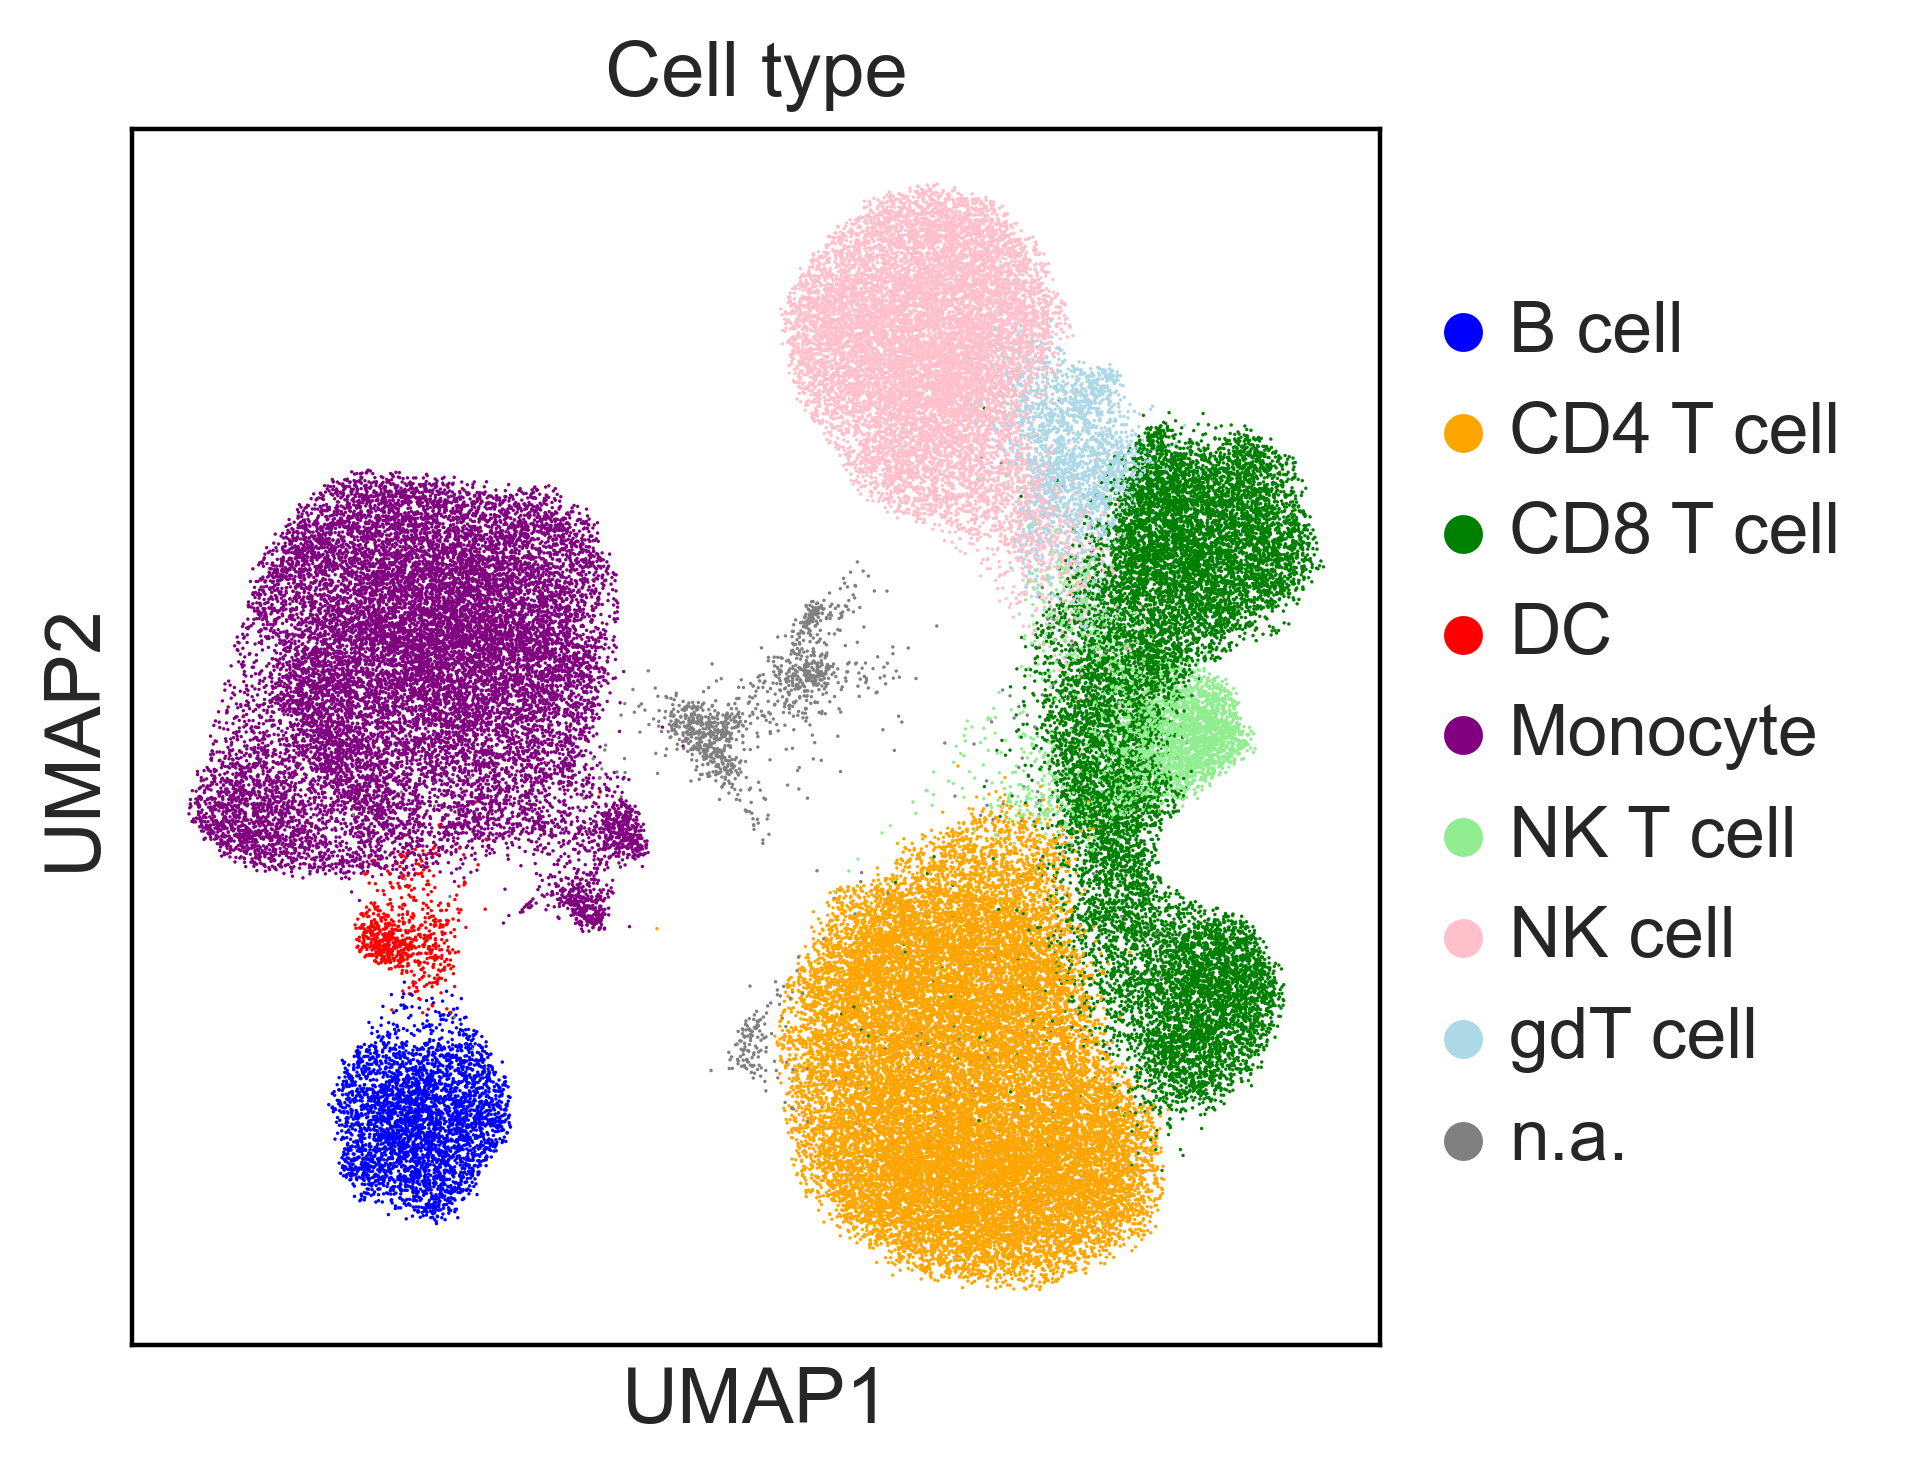

In [43]:
sc.pl.umap(all_samples, color='Cell type', save='fig1_cell_types.pdf', palette=color_dict)

# 1d: Cell Type Frequencies, Stacked Bar Plots

In [44]:
tp_converter = {'week2': 0, 'week4': 1, 'week6': 2}

# count occurrences of each cell type
rna_cell_type_composition = {}

for cell_nr in range(all_samples.shape[0]):
    cell_type = all_samples.obs['Cell type'][cell_nr]
    cs = all_samples.obs['clinical_score'][cell_nr]
    if (cell_type + '_' + str(cs)) not in rna_cell_type_composition.keys():
        rna_cell_type_composition[(cell_type + '_' + str(cs))] = [0, 0, 0]
    if ('allcells_' + str(cs)) not in rna_cell_type_composition.keys():
        rna_cell_type_composition[('allcells_' + str(cs))] = [0, 0, 0]
    rna_cell_type_composition[(cell_type + '_' + str(cs))][tp_converter[all_samples.obs['timepoint'][cell_nr]]] += 1
    rna_cell_type_composition[('allcells_' + str(cs))][tp_converter[all_samples.obs['timepoint'][cell_nr]]] += 1

In [45]:
# cell type composition as measured by flow cytometry
prot_cell_type_composition = {
    'Monocyte_0': [188, 46, 99], 'Monocyte_11': [717, 336, 229], 'Monocyte_14': [456, 204, 161],
    'Monocyte_17': [7, 27, 96], 'Monocyte_19': [45, 154, 80], 'Monocyte_26': [60, 214, 242],
    'CD4 T cell_0': [540, 95, 460], 'CD4 T cell_11': [756, 394, 323], 'CD4 T cell_14': [1281, 380, 467],
    'CD4 T cell_17': [62, 163, 452], 'CD4 T cell_19': [175, 366, 333], 'CD4 T cell_26': [214, 564, 866],
    'CD8 T cell_0': [292, 44, 209], 'CD8 T cell_11': [748, 436, 335], 'CD8 T cell_14': [445, 140, 124],
    'CD8 T cell_17': [17, 56, 230], 'CD8 T cell_19': [70, 161, 176], 'CD8 T cell_26': [91, 238, 219],
    'NK_0': [248, 41, 174], 'NK_11': [459, 82, 82], 'NK_14': [682, 227, 183],
    'NK_17': [10, 45, 239], 'NK_19': [54, 141, 76], 'NK_26': [84, 161, 478],
    'Treg_0': [22, 2, 19], 'Treg_11': [37, 12, 7], 'Treg_14': [67, 18, 27],
    'Treg_17': [2, 7, 9], 'Treg_19': [8, 14, 22], 'Treg_26': [10, 27, 28],
}

In [46]:
all_cells_dict = {}
for key in prot_cell_type_composition.keys():
    patient = key.split('_')[1]
    if ('allcells_' + str(patient)) not in all_cells_dict.keys():
        all_cells_dict[('allcells_' + str(patient))] = [0, 0, 0]
    for i in range(3):
        all_cells_dict[('allcells_' + str(patient))][i] += prot_cell_type_composition[key][i]

prot_cell_type_composition.update(all_cells_dict)

In [47]:
print(list(set(all_samples.obs['Cell type'])))

['B cell', 'gdT cell', 'NK T cell', 'Monocyte', 'NK cell', 'CD8 T cell', 'n.a.', 'DC', 'CD4 T cell']


In [ ]:
for patient_cs in [0, 11, 14, 17, 19, 26]:
    column_list = ['annotation']
    column_list.extend(list(set(all_samples.obs['Cell type'])))
    df = pd.DataFrame(
        columns=['annotation', 'CD4 T cell', 'CD8 T cell', 'gdT cell', 'NK T cell', 'NK cell', 'Monocyte', 'DC', 'B cell', 'Treg cell', 'n.a.'])
    for kind in ['prot', 'rna']:
        for tp in range(3):
            if kind == 'prot':
                perc = {}
                for entry in prot_cell_type_composition.keys():
                    if int(entry.split('_')[1]) == patient_cs and entry.split('_')[0] != 'allcells':
                        perc[entry.split('_')[0]] = prot_cell_type_composition[entry][tp] / \
                                                    prot_cell_type_composition[('allcells_' + str(patient_cs))][
                                                        tp] * 100
                df.loc[len(df.index)] = [('FACS Week ' + str((tp + 1) * 2)), perc['CD4 T cell'],
                                         perc['CD8 T cell'], 0, 0, perc['NK'], perc['Monocyte'], 0, 0, perc['Treg'], 0]
            else:
                perc = {}
                for entry in rna_cell_type_composition.keys():
                    if int(entry.split('_')[1]) == patient_cs and entry.split('_')[0] != 'allcells':
                        perc[entry.split('_')[0]] = rna_cell_type_composition[entry][tp] / \
                                                    rna_cell_type_composition[('allcells_' + str(patient_cs))][tp] * 100
                df.loc[len(df.index)] = [('scRNA Week ' + str((tp + 1) * 2)), perc['CD4 T cell'],
                                         perc['CD8 T cell'], perc['gdT cell'], perc['NK T cell'], perc['NK cell'], perc['Monocyte'], perc['DC'], perc['B cell'], 0, perc['n.a.']]
    fig = df.plot(x='annotation', kind='bar', stacked=True,
                  title=('Clinical score ' + str(patient_cs)),
                  ylabel="Cell type composition [%]",
                  xlabel='',
                  figsize=(3.5, 4),
                  color=color_dict,
                  legend=None).get_figure()
    #plt.legend(bbox_to_anchor =(0.5, 1.3), ncol = 10)
    fig.savefig(f'{save_path}/stacked_bar_patient_{patient_cs}.pdf', bbox_inches='tight')

# 1e: Cell Type Frequencies, Mean with SEM

In [49]:
# healthy physiological range of cell type composition
physiological_range = {'CD4 T cell': [13.334, 66.667],
                       'CD8 T cell': [6.667, 36.667],
                       'gdT cell': [0.7, 4.5],
                       'NK cell': [3.334, 20],
                       'NK T cell': [0.007, 0.45],
                       'Monocyte': [6.667, 40],
                       'DC': [1, 3],
                       'B cell': [3.334, 23.334]}

In [50]:
# creates plot of mean cell type composition with standard error over time
def mean_with_sem_for_cell_type(ct, lower_top, higher_top, plot_top, text_offset):
    w2, w4, w6 = [], [], []
    for patient_cs in [0, 11, 14, 17, 19, 26]:
        values = rna_cell_type_composition[f'{ct}_{patient_cs}']
        values = [((v / rna_cell_type_composition[('allcells_' + str(patient_cs))][indx]) * 100)
                  for indx, v in enumerate(values)]

        w2.append(values[0])
        w4.append(values[1])
        w6.append(values[2])

    plt.plot(['Week 2', 'Week 4', 'Week 6'], 3 * [physiological_range[ct][0]], linestyle='dashed', color='black',
             linewidth=1.2)
    plt.plot(['Week 2', 'Week 4', 'Week 6'], 3 * [physiological_range[ct][1]], linestyle='dashed', color='black',
             linewidth=1.2)

    y_mean = [statistics.mean(w2), statistics.mean(w4), statistics.mean(w6)]
    y_sem = [scistats.sem(w2), scistats.sem(w4), scistats.sem(w6)]
    x_tp = ['Week 2', 'Week 4', 'Week 6']
    plt.plot(x_tp, y_mean, color=color_dict[ct], linewidth=3.0)
    plt.fill_between(x_tp, np.asarray(y_mean) - np.asarray(y_sem), np.asarray(y_mean) + np.asarray(y_sem),
                     color=color_dict[ct], alpha=0.45, linewidth=0)

    p_adj_week2vs4 = scistats.ranksums(w2, w4, alternative='two-sided')[1]
    p_adj_week2vs6 = scistats.ranksums(w2, w6, alternative='two-sided')[1]
    p_adj_week4vs6 = scistats.ranksums(w4, w6, alternative='two-sided')[1]

    plt.annotate("", xy=(0.1, lower_top), xytext=(0.9, lower_top),
                 arrowprops={'arrowstyle': '-'}, va='center', color='black')
    plt.annotate("", xy=(1.1, lower_top), xytext=(1.9, lower_top),
                 arrowprops={'arrowstyle': '-'}, va='center', color='black')
    plt.annotate("", xy=(0.1, higher_top), xytext=(1.9, higher_top),
                 arrowprops={'arrowstyle': '-'}, va='center', color='black')

    if p_adj_week2vs6 == 0 or p_adj_week2vs6 >= 1:
        plt.annotate(min(int(p_adj_week2vs6), 1), xy=(1, higher_top + text_offset), fontsize=11)
    else:
        plt.annotate('{:.2e}'.format(p_adj_week2vs6), xy=(0.7, higher_top + text_offset), fontsize=11)

    if p_adj_week2vs4 == 0 or p_adj_week2vs4 >= 1:
        plt.annotate(min(int(p_adj_week2vs4), 1), xy=(0.4, lower_top + text_offset), fontsize=11)
    else:
        plt.annotate('{:.2e}'.format(p_adj_week2vs4), xy=(0.25, lower_top + text_offset), fontsize=11)
    if p_adj_week4vs6 == 0 or p_adj_week4vs6 >= 1:
        plt.annotate(min(int(p_adj_week4vs6), 1), xy=(1.4, lower_top + text_offset), fontsize=11)
    else:
        plt.annotate('{:.2e}'.format(p_adj_week4vs6), xy=(1.25, lower_top + text_offset), fontsize=11)

    plt.ylim(bottom=0, top=plot_top)
    plt.title(f'{ct}s')
    plt.ylabel('Cell type composition [%]')
    plt.savefig(f'{save_path}/{ct}.pdf', bbox_inches='tight')
    plt.close()

In [51]:
plt.rcParams["figure.figsize"] = (3, 3)
mean_with_sem_for_cell_type('NK cell', 22, 26, 30, 0.5)
mean_with_sem_for_cell_type('NK T cell', 6.2, 7.5, 9, 0.2)
mean_with_sem_for_cell_type('CD4 T cell', 47, 55, 70, 0.7)
mean_with_sem_for_cell_type('CD8 T cell', 25, 30, 42, 0.8)
mean_with_sem_for_cell_type('Monocyte', 43, 50, 58, 1)
mean_with_sem_for_cell_type('DC', 1.9, 2.3, 3.2, 0.06)
mean_with_sem_for_cell_type('B cell', 14, 17, 25, 0.3)
mean_with_sem_for_cell_type('gdT cell', 6.7, 8, 10, 0.2)

In [ ]:
sc.pl.umap(all_samples, color='HIF1A', save='_hif1a.pdf')